# Vertex Tabular Binary Classification with .CustomJob()

<center><img src="../images/03.png"/></center>

## Set Constants

In [1]:
PROJECT_ID = 'jchavezar-demo'
REGION = 'us-central1'
DATASETS_URI = 'gs://vtx-datasets-public/ecommerce'
MODEL_URI = 'gs://vtx-models/ecommerce'
STAGING_URI = 'gs://vtx-staging/ecommerce/'
TRAIN_IMAGE_URI = f'gcr.io/{PROJECT_ID}/03cb-tf-hpt-xai-train:latest'
PREDICTION_IMAGE_URI = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-9:latest'
SERIES = '03cb'
EXPERIMENT_NAME = 'ecommerce-exp'

## Create Folder Structure

```
tmp
└─── source
     |  setup.py
     |
     └─── trainer
          |  __init__.py
          |  train.py
          |

```

In [2]:
!rm -fr source
!mkdir -p source/trainer

## Create Python Source Distribution Files 

In [3]:
%%writefile source/trainer/train.py

import os
import time
import warnings
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
warnings.filterwarnings('ignore')

################################### ARGUMENTS #######################################


parser = argparse.ArgumentParser()
parser.add_argument(
    '--train_data_uri', 
    help = 'dataset to train',
    type = str
)
parser.add_argument(
    '--val_data_uri', 
    help = 'val to train',
    type = str
)
parser.add_argument(
    '--test_data_uri', 
    help = 'test to train',
    type = str
)
args = parser.parse_args()

train_df = pd.read_csv(args.train_data_uri)
val_df = pd.read_csv(args.val_data_uri)
test_df = pd.read_csv(args.test_data_uri)
print('test')

################################### PREPROCESSING #######################################

## Convert pandas dataframe to tensor data (from GCS to TF.data.Data)
init_start = time.process_time()
def df_to_dataset(dataframe, shuffle=None):
    df = dataframe.copy()
    labels = df.pop('will_buy_on_return_visit')
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
      
## Normalization / Standarization
def get_normalization_layer(name, dataset):
    start = time.process_time()
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    print(f'Normalization time for {name}: {time.process_time() - start}')
    return normalizer

# Performs feature-wise categorical encoding of inputs features
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    start = time.process_time()
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    print(f'Encoding time for {name}: {time.process_time() - start}')
    return lambda feature: encoder(index(feature))

batch_size = 256
train_ds = df_to_dataset(train_df)
val_ds = df_to_dataset(val_df)
test_ds = df_to_dataset(test_df)

## Identify Numerical and Categorical columns:
num_columns = ['latest_ecommerce_progress', 'time_on_site', 'pageviews']
cat_columns = ['source', 'medium', 'channelGrouping', 'deviceCategory', 'country']
num_cat_columns = 'bounces'

all_inputs = []
encoded_features = []

# Numerical Features.
for header in num_columns:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)
    
# Categorical Features.
for header in cat_columns:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                 dataset=train_ds,
                                                 dtype='string',
                                                 max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

## Integer values into integer indices.
bounces_col = tf.keras.Input(shape=(1,), name=num_cat_columns, dtype='int64')

encoding_layer = get_category_encoding_layer(name=num_cat_columns,
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(bounces_col)
all_inputs.append(bounces_col)
encoded_features.append(encoded_age_col)

print(f'Total preprocessing time: {time.process_time() - init_start}')

#########################################################################################


################################### CREATE, COMPILE AND TRAIN MODEL #####################

all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print('compile pass')
################################## SETUP TENSORBOARD LOGS AND TRAIN #####################

print(os.environ['AIP_TENSORBOARD_LOG_DIR'])
print('---------------------')
print(os.environ['AIP_MODEL_DIR'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.environ['AIP_TENSORBOARD_LOG_DIR'], update_freq='batch', histogram_freq=0)
model.fit(train_ds, epochs=15, validation_data=val_ds, callbacks=[tensorboard_callback])
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

################################### SAVE MODEL ##########################################

model.save(os.environ['AIP_MODEL_DIR'])

Writing source/trainer/train.py


In [10]:
%%writefile source/Dockerfile
FROM python:3.9.12

COPY . /

RUN pip install tensorflow && \
    pip install google-cloud-storage && \
    pip install pandas && \
    pip install gcsfs

ENTRYPOINT ["python", "trainer/train.py"]

Overwriting source/Dockerfile


In [11]:
!gcloud builds submit -t $TRAIN_IMAGE_URI source/.

Creating temporary tarball archive of 2 file(s) totalling 5.7 KiB before compression.
Uploading tarball of [source/.] to [gs://jchavezar-demo_cloudbuild/source/1669853019.395052-636f873d22904121815a293c6967c7a1.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/e3838133-e018-4c6a-ae33-e9c39814854d].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/e3838133-e018-4c6a-ae33-e9c39814854d?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "e3838133-e018-4c6a-ae33-e9c39814854d"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1669853019.395052-636f873d22904121815a293c6967c7a1.tgz#1669853019656330
Copying gs://jchavezar-demo_cloudbuild/source/1669853019.395052-636f873d22904121815a293c6967c7a1.tgz#1669853019656330...
/ [1 files][  2.2 KiB/  2.2 KiB]                                                
Operation completed over 1 ob

## Create Tensorboard

In [12]:
from google.cloud import aiplatform as aip

tb = aip.Tensorboard.list(filter=f"labels.series={SERIES}")
if tb:
    tb = tb[0]
else: 
    tb = aip.Tensorboard.create(display_name=SERIES, labels={'series' : f'{SERIES}'})

## Create Vertex Training from Code [CustomJob]

In [13]:
aip.init(
    experiment=EXPERIMENT_NAME,
    experiment_tensorboard=tb.resource_name,
    project=PROJECT_ID,
    location=REGION)


worker_pool_specs = [
    {
        'machine_spec' : {
            'machine_type': 'n1-standard-4'
        },
        'replica_count': 1,
        'container_spec': {
            'image_uri': TRAIN_IMAGE_URI,
            'args': [
                '--train_data_uri='+f'{DATASETS_URI}/train.csv',
                '--val_data_uri='+f'{DATASETS_URI}/val.csv',
                '--test_data_uri='+f'{DATASETS_URI}/test.csv',
            ]
        }
    }
]

job = aip.CustomJob(
    display_name = 'ecommerce_tf',
    worker_pool_specs = worker_pool_specs,
    base_output_dir = MODEL_URI,
    staging_bucket = STAGING_URI
)

model = job.run(
    service_account = 'vtx-pipe@jchavezar-demo.iam.gserviceaccount.com',
    tensorboard = tb.resource_name
)

Creating CustomJob
CustomJob created. Resource name: projects/569083142710/locations/us-central1/customJobs/4124101127459307520
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/569083142710/locations/us-central1/customJobs/4124101127459307520')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4124101127459307520?project=569083142710
View Tensorboard:
https://us-central1.tensorboard.googleusercontent.com/experiment/projects+569083142710+locations+us-central1+tensorboards+157986626771877888+experiments+4124101127459307520
CustomJob projects/569083142710/locations/us-central1/customJobs/4124101127459307520 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/4124101127459307520 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/4124101127459307520 current state:
JobState.JOB_STATE_PENDING
CustomJo

RuntimeError: Job failed with:
code: 3
message: "The replica workerpool0-0 exited with a non-zero status of 1. To find out more about why your job exited please check the logs: https://console.cloud.google.com/logs/viewer?project=569083142710&resource=ml_job%2Fjob_id%2F4124101127459307520&advancedFilter=resource.type%3D%22ml_job%22%0Aresource.labels.job_id%3D%224124101127459307520%22"


## Get Model Information from Tensorflow Graph

2022-12-01 00:20:40.808583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 00:20:41.034058: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-01 00:20:42.030887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-01 00:20:42.031002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

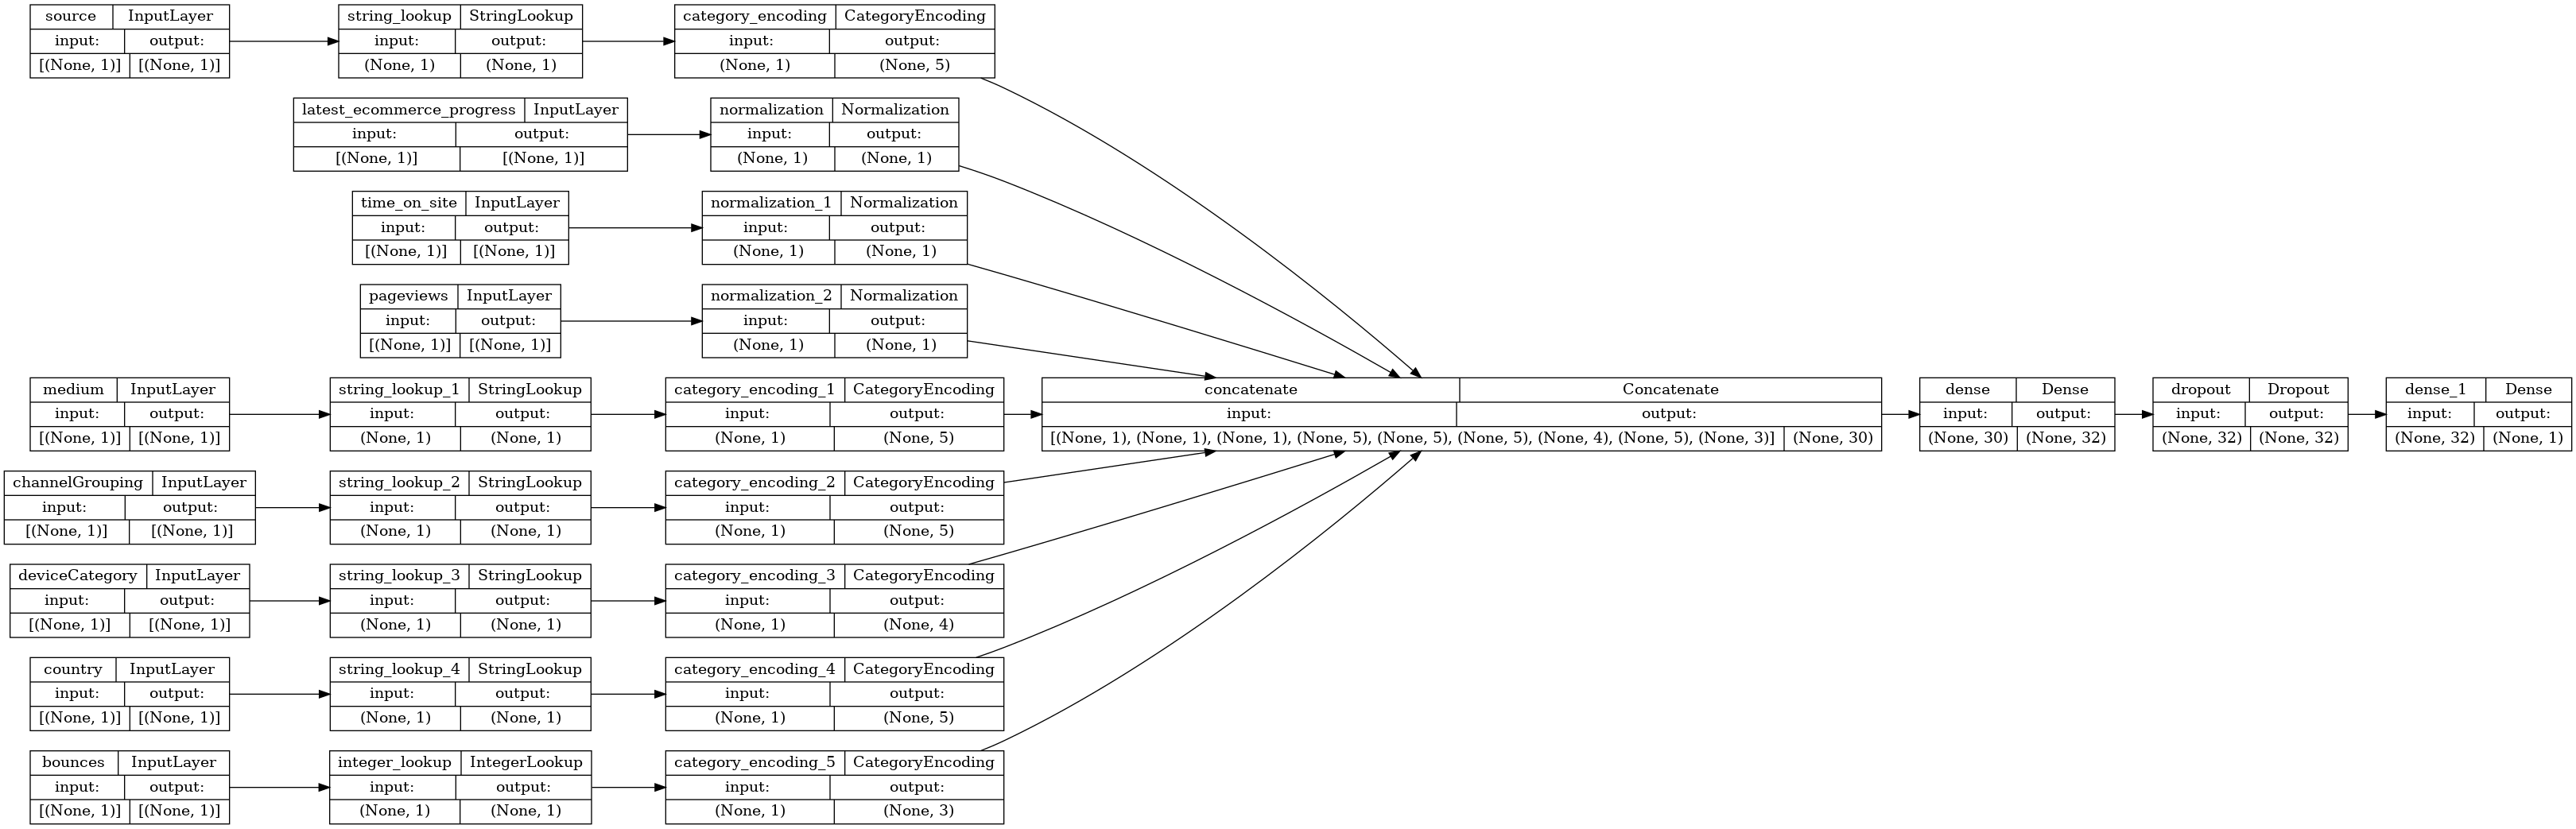

In [14]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

loaded_model = tf.keras.models.load_model(f"{MODEL_URI}/model")
tf.keras.utils.plot_model(loaded_model, show_shapes=True, rankdir="LR")

## Build Explainable AI Metadata from Graph

In [15]:
infer = loaded_model.signatures['serving_default']
print(infer.inputs)
print()
print(infer.structured_outputs)

[<tf.Tensor 'bounces:0' shape=(None, 1) dtype=int64>, <tf.Tensor 'channelgrouping:0' shape=(None, 1) dtype=string>, <tf.Tensor 'country:0' shape=(None, 1) dtype=string>, <tf.Tensor 'devicecategory:0' shape=(None, 1) dtype=string>, <tf.Tensor 'latest_ecommerce_progress:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'medium:0' shape=(None, 1) dtype=string>, <tf.Tensor 'pageviews:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'source:0' shape=(None, 1) dtype=string>, <tf.Tensor 'time_on_site:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=int64>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=int64>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=int64>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=int64>, <tf.Tensor 'unknown_7:0' shape=() dtype=resource>, <tf.Tensor 'unknown_8:0' sha

In [16]:
EXPLANATION_METADATA = {
    "outputs": {
        "logit": { 
            "output_tensor_name": "dense_1"
        }
    },
    "inputs": { 
        "latest_ecommerce_progress": {},
        "bounces": {},
        "time_on_site": {},
        "pageviews": {},
        "source": {},
        "medium": {},
        "channelGrouping": {},
        "deviceCategory": {},
        "country": {},
    }
}
EXPLANATION_PARAMS = {"sampled_shapley_attribution": {"path_count": 5}}

## Upload Model

In [17]:
model = aip.Model.upload(
    display_name = '03-cb-ecommerce_tf',
    serving_container_image_uri = PREDICTION_IMAGE_URI,
    artifact_uri = f'{MODEL_URI}/model',
    explanation_parameters=EXPLANATION_PARAMS,
    explanation_metadata=EXPLANATION_METADATA,
)

Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/6056499272906440704/operations/454691282636242944
Model created. Resource name: projects/569083142710/locations/us-central1/models/6056499272906440704@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/6056499272906440704@1')


## Deploy Model On Endpoint

In [18]:
endpoint = model.deploy(
    deployed_model_display_name = '03cb-ecommerce_tf_ep_dep',
    traffic_percentage = 100,
    machine_type = 'n1-standard-4',
    min_replica_count = 1,
    max_replica_count = 1,
    explanation_metadata=EXPLANATION_METADATA,
    explanation_parameters=EXPLANATION_PARAMS
)

Creating Endpoint
Create Endpoint backing LRO: projects/569083142710/locations/us-central1/endpoints/1456531849407889408/operations/8141209946650836992
Endpoint created. Resource name: projects/569083142710/locations/us-central1/endpoints/1456531849407889408
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/569083142710/locations/us-central1/endpoints/1456531849407889408')
Deploying model to Endpoint : projects/569083142710/locations/us-central1/endpoints/1456531849407889408
Deploy Endpoint model backing LRO: projects/569083142710/locations/us-central1/endpoints/1456531849407889408/operations/5306193981221109760
Endpoint model deployed. Resource name: projects/569083142710/locations/us-central1/endpoints/1456531849407889408


## Testing Predictions

In [23]:
instance = {
    'latest_ecommerce_progress': [0],
    'bounces': [0],
    'time_on_site': [103],
    'pageviews': [3],
    'source': ['youtube.com'],
    'medium': ['referral'],
    'channelGrouping': ['Social'],
    'deviceCategory': ['desktop'],
    'country': ['Vietnam'],
}

In [20]:
endpoint.predict([instance])

Prediction(predictions=[[-10.7887411]], deployed_model_id='5697348197739921408', model_version_id='1', model_resource_name='projects/569083142710/locations/us-central1/models/6056499272906440704', explanations=None)

In [25]:
explanations = endpoint.explain([instance])
print("Explainable predictions:", explanations)

Explainable predictions: Prediction(predictions=[[-10.7887411]], deployed_model_id='5697348197739921408', model_version_id=None, model_resource_name=None, explanations=[attributions {
  baseline_output_value: -7.0977325439453125
  instance_output_value: -10.788740158081055
  feature_attributions {
    struct_value {
      fields {
        key: "bounces"
        value {
          list_value {
            values {
              number_value: 0.0
            }
          }
        }
      }
      fields {
        key: "channelGrouping"
        value {
          list_value {
            values {
              number_value: -1.425240325927734
            }
          }
        }
      }
      fields {
        key: "country"
        value {
          list_value {
            values {
              number_value: 0.3484356880187988
            }
          }
        }
      }
      fields {
        key: "deviceCategory"
        value {
          list_value {
            values {
              num

<BarContainer object of 9 artists>

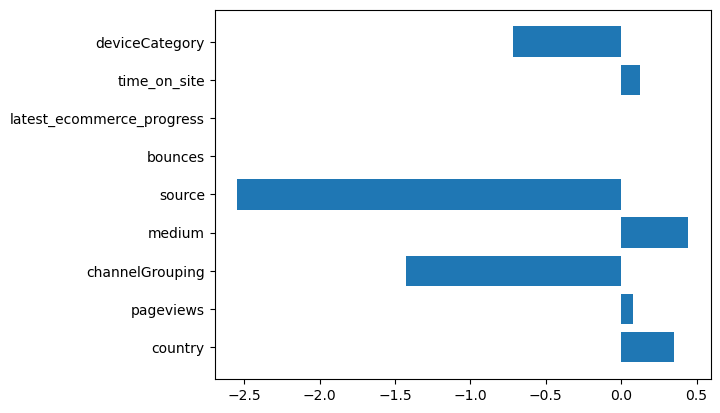

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

results = {k:v for k,v in explanations[4][0].attributions[0].feature_attributions.items()}
names = list(results.keys())
values = []
for i in results.values():
    values.append(i.pop())
    
plt.barh(range(len(results)), values, tick_label=names)

## Cleaning

In [ ]:
!rm -f source.tar source.tar.gz
!rm -fr source